In [23]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

In [3]:
# ANOVA 하기 위한 코드
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 오류 무시
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [4]:
# Prophet
from fbprophet import Prophet

# 그룹화 시계열
import hts   # gts가 여기에 포함됨
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16,8)

In [5]:
%matplotlib inline

from pathlib import Path
import pandas as pd

from sklearn import preprocessing 
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans #k-평균 모델 구축
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots


# 페이스북이 만든, Prophet 시계열 예측 라이브러리 이용

> ARIMA 같은 시계열 모델은 시간에 종속적인 구조를 가지지만, Prophet은 종속적이지 않고 Curve Fitting으로 문제 해결
>
> 구성요소로는 Growth, Seasonality, Holidays가 있으며 \[y(t)=g(t)+s(t)+h(t)+error\]구조를 취함
>
> 데이터를 Prophet에 맞도록 가공하기 위해 ds, y 2개의 colum이 필요함
>
> Prophet 객체는 1번만 Fit할 수 있음. default growth = 'linear'이고, 상한과 하한을 설정할 경우에는 Prophet의 growh = 'logistic'을 추가 
>
> 미래 dataframe 생성
> 
> 예측 후 forecast 결과 확인 

## month_long_term_frgn 장기체류

1. sum_resd_pop_cnt  ~ nationality group별로

2. sum_visit_pop_cnt ~ nationality group별로

In [6]:
long_df = pd.read_csv(r'C:\Users\이현아\Desktop\월별데이터 정리\month_long_term_frgn.csv')
long_df

,m,nationality,emd_cd,emd_nm,count_num,sum_resd_pop_cnt,sum_work_pop_cnt,sum_visit_pop_cnt
0,2018-01,AUS,50110590,건입동,33,0.0000,0.0000,193.1805
1,2018-01,AUS,50110256,구좌읍,40,0.0000,0.0000,251.2195
2,2018-01,AUS,50130253,남원읍,107,0.0000,0.0000,648.0345
3,2018-01,AUS,50110660,노형동,761,11855.9924,738.9594,2612.7042
4,2018-01,AUS,50130590,대륜동,563,2701.0357,1576.0168,200.4630
...,...,...,...,...,...,...,...,...
52233,2021-06,VNM,50130320,표선면,919,2646.5554,0.0000,7603.5847
52234,2021-06,VNM,50110310,한경면,1366,45349.6490,1121.2861,75816.8162
52235,2021-06,VNM,50110250,한림읍,1440,97147.6156,3820.6787,61844.2041
52236,2021-06,VNM,50110600,화북동,1375,13436.5104,2574.8044,8554.9721


In [7]:
long_df['nationality'].unique()

array(['AUS', 'BGD', 'CAN', 'CHN', 'DEU', 'EGY', 'ETC', 'FRA', 'GBR',
       'IDN', 'IND', 'JPN', 'KAZ', 'KGZ', 'KHM', 'LKA', 'MGL', 'MMR',
       'MYS', 'NGR', 'NPL', 'NZL', 'PAK', 'PHL', 'RUS', 'THA', 'TWN',
       'UKR', 'USA', 'UZB', 'VNM'], dtype=object)

### 1. grouping

In [8]:
group1 = ['CHN']
group2 = ['NPL','USA']
group3 = ['IDN']
group4 = ['VNM']
group5 = ['AUS','BGD','CAN','DEU','EGY','ETC','FRA','GBR','IND','JPN','KAZ','KGZ','KHM','LKA','MGL','MMR','MYS','NGR','NZL','PAK','PHL','RUS','THA','TWN','UKR','UZB']

In [9]:
for i in long_df.index:
    if long_df.loc[i,'nationality'] in group1:
        long_df.loc[i,'nationality_group'] = 'group1'

In [10]:
for i in long_df.index:
    if long_df.loc[i,'nationality'] in group2:
        long_df.loc[i,'nationality_group'] = 'group2'

In [11]:
for i in long_df.index:
    if long_df.loc[i,'nationality'] in group3:
        long_df.loc[i,'nationality_group'] = 'group3'

In [12]:
for i in long_df.index:
    if long_df.loc[i,'nationality'] in group4:
        long_df.loc[i,'nationality_group'] = 'group4'

In [13]:
for i in long_df.index:
    if long_df.loc[i,'nationality'] in group5:
        long_df.loc[i,'nationality_group'] = 'group5'

In [14]:
long_df['nationality_group'].unique()

array(['group5', 'group1', 'group3', 'group2', 'group4'], dtype=object)

In [15]:
long_df['nationality_group'].value_counts()

group5    43208
group2     3612
group3     1806
group4     1806
group1     1806
Name: nationality_group, dtype: int64

### 데이터 전처리

In [16]:
# 우선, 시계열 데이터이므로 날짜를 datetime형식으로 변환
long_df['m'] = pd.to_datetime(long_df.m, format = '%Y-%m')

In [17]:
# 동, 읍, 면 이름 확인
region = long_df['emd_nm'].unique()
region = sorted(region)

#### 1. sum_resd_pop_cnt

KeyError: 'yhat'

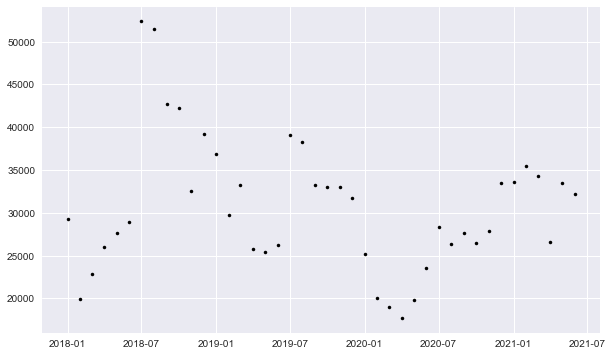

In [20]:
# 1. sum_resd_pop_cnt
# 국적(nationality) 그룹별로 예측하기
total_long_resd = []  # 각 지역별 sum_resd_cnt의 7,8월 예측값 담을 리스트
for c in region:
    sum_july1 = 0     # 해당 지역의 7월 예측값
    sum_august1 = 0   # 해당 지역의 8월 예측값
    new_df = long_df[long_df['emd_nm']==c]
    new_df = new_df.rename(columns = {'m' : 'ds', 'sum_resd_pop_cnt' : 'y'})
    df_grouped = new_df.groupby('nationality_group')   
    df_final1 = pd.DataFrame()        # 예측값 넣을 dataframe
    for g in df_grouped.groups:
        group = df_grouped.get_group(g)
        m = Prophet()  # Prophet 적용
        m.daily_seasonality=True
        m.weekly_seasonality=True
        m.fit(group)   # 그룹별로 fit
        future = m.make_future_dataframe(freq ='M', periods=2)
        forecast = m.predict(future)
        forecast = forecast.rename(columns={'yhat': 'yhat_'+g})   # 이름을 yhat + group
        df_final1 = pd.merge(df_final1, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)
    df_final1 = df_final1[['yhat_' + g for g in df_grouped.groups.keys()]]
    print(c + "그룹별 예측 결과")
    for i in range(5):
        sum_july1 += df_final1.iloc[-2,i]
        sum_august1 += df_final1.iloc[-1,i]
    print(f'7월의 sum_resd_pop_cnt(거주 인구 합) : {sum_july1}')
    print(f'8월의 sum_resd_pop_cnt(거주 인구 합) : {sum_august1}')
    total_long_resd.append(sum_july1)
    total_long_resd.append(sum_august1)

In [334]:
total_long_resd = pd.DataFrame(total_long_resd)
total_long_resd= total_long_resd.rename(columns = {0 : 'long_resd'})
total_long_resd.to_csv("장기체류_거주인구.csv",mode='w')

In [189]:
# 2. sum_visit_pop_cnt
# 국적(nationality) 그룹별로 예측하기
total_long_visit = []     # 각 동별 sum_visit_cnt의 7,8월 예측값 담을 리스트
for c in region:
    sum_july2 = 0
    sum_august2 = 0
    new_df = long_df[long_df['emd_nm']==c]
    new_df = new_df.rename(columns = {'m' : 'ds', 'sum_visit_pop_cnt' : 'y'})
    df_grouped = new_df.groupby('nationality_group')   
    df_final2 = pd.DataFrame()
    for g in df_grouped.groups:
        group = df_grouped.get_group(g)
        m = Prophet()
        m.daily_seasonality=True
        m.weekly_seasonality=True
        m.fit(group)
        future = m.make_future_dataframe(freq ='M', periods=2)
        forecast = m.predict(future)
        forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
        df_final2 = pd.merge(df_final2, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

    df_final2 = df_final2[['yhat_' + g for g in df_grouped.groups.keys()]]
    print(c + " 그룹별 예측 결과")
    for i in range(5):
        sum_july2 += df_final2.iloc[-2,i]
        sum_august2 += df_final2.iloc[-1,i]
    print(f'7월의 sum_visit_pop_cnt(방문 인구 합) : {sum_july2}')
    print(f'8월의 sum_visit_pop_cnt(방문 인구 합) : {sum_august2}')
    total_long_visit.append(sum_july2)
    total_long_visit.append(sum_august2)

건입동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 137177.78662951305
8월의 sum_visit_pop_cnt(방문 인구 합) : 218305.90620717462
구좌읍 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 70876.4132718484
8월의 sum_visit_pop_cnt(방문 인구 합) : 255916.61013910826
남원읍 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 185832.2778973061
8월의 sum_visit_pop_cnt(방문 인구 합) : 206713.06265903436
노형동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 298791.5422655778
8월의 sum_visit_pop_cnt(방문 인구 합) : 529539.9289740208
대륜동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 51683.25248822802
8월의 sum_visit_pop_cnt(방문 인구 합) : 130731.08137481188
대정읍 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 174989.990414961
8월의 sum_visit_pop_cnt(방문 인구 합) : 351519.63782250154
대천동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 5090.571509145679
8월의 sum_visit_pop_cnt(방문 인구 합) : 114973.79781532047
도두동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 48325.44569502522
8월의 sum_visit_pop_cnt(방문 인구 합) : 58436.4447231182
동홍동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 75879.18338654244
8월의

In [336]:
total_long_visit = pd.DataFrame(total_long_visit)
total_long_visit= total_long_visit.rename(columns = {0 : 'long_visit'})
total_long_visit.to_csv("장기체류_방문인구.csv",mode='w')

데이터 값이 0에 근접해 있다면, 계절변동에 의해 negative(음수)의 예측값을 내놓을 수 있음. 
따라서 이경우, 음수인 예측값들은 0으로 생각.

## month_short_term_frgn 단기체류

3. visit_pop_cnt ~ nationality group별로

In [190]:
short_df = pd.read_csv(r'C:\Users\이현아\Desktop\월별데이터 정리\month_short_term_frgn.csv')
short_df

,m,nationality,count_num,emd_cd,emd_nm,visit_pop_cnt
0,2018-01,CHN,744,50110590,건입동,30589.4398
1,2018-01,CHN,744,50110256,구좌읍,26691.1513
2,2018-01,CHN,744,50130253,남원읍,179846.0273
3,2018-01,CHN,744,50110660,노형동,145583.1902
4,2018-01,CHN,742,50130590,대륜동,22743.8459
...,...,...,...,...,...,...
16250,2021-06,VNM,126,50110320,추자면,36.6789
16251,2021-06,VNM,39,50130320,표선면,9.2223
16252,2021-06,VNM,45,50110310,한경면,11.1088
16253,2021-06,VNM,37,50110250,한림읍,7.7552


In [191]:
short_df['nationality'].unique()

array(['CHN', 'ETC', 'HKG', 'IDN', 'JPN', 'MYS', 'SGP', 'THA', 'USA',
       'VNM'], dtype=object)

### 1. grouping

In [192]:
group1= ['VNM']
group2 = ['JPN','SGP','IDN','MYS']
group3 = ['USA','CHN','ETC']
group4 = ['HKG','THA']

In [193]:
for i in short_df.index:
    if short_df.loc[i,'nationality'] in group1:
        short_df.loc[i,'nationality_group'] = 'group1'
    elif short_df.loc[i,'nationality'] in group2:
        short_df.loc[i,'nationality_group'] = 'group2'
    elif short_df.loc[i,'nationality'] in group3:
        short_df.loc[i,'nationality_group'] = 'group3'
    elif short_df.loc[i,'nationality'] in group4:
        short_df.loc[i,'nationality_group'] = 'group4'

In [397]:
short_df['nationality_group'].value_counts()

group2    6130
group3    5397
group4    3320
group1    1408
Name: nationality_group, dtype: int64

### 데이터 전처리

In [259]:
# 우선, 시계열 데이터이므로 날짜를 datetime형식으로 변환
short_df['m'] = pd.to_datetime(short_df.m, format = '%Y-%m')

In [350]:
# 동, 읍, 면 이름 확인
region = short_df['emd_nm'].unique()
region = sorted(region)

43

##### 4. visit_pop_cnt

# 이거 실행!

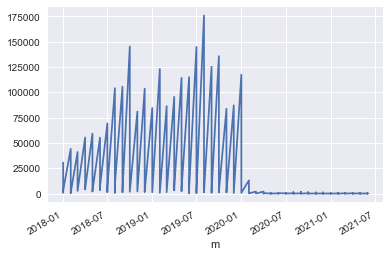

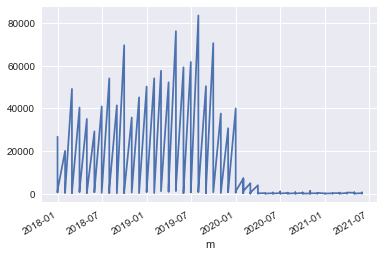

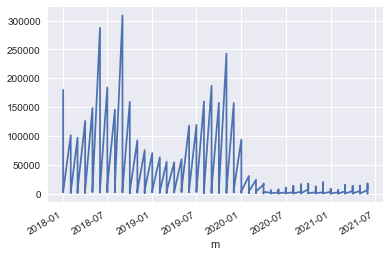

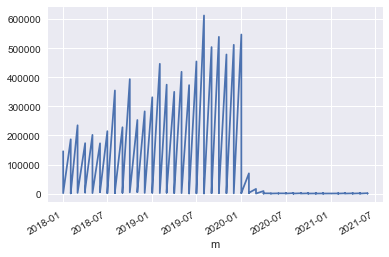

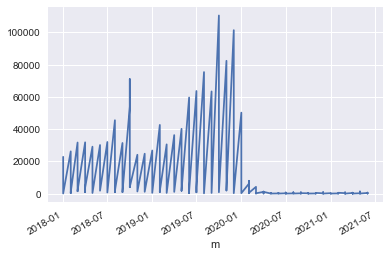

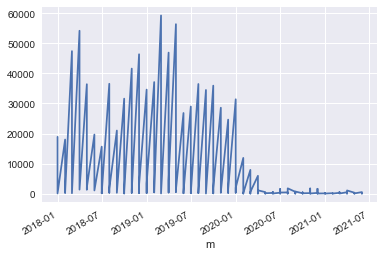

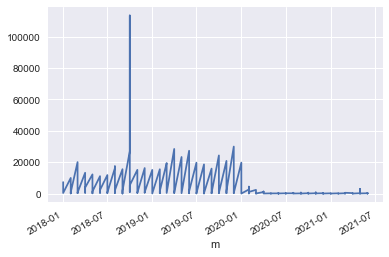

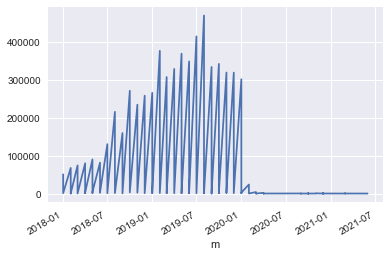

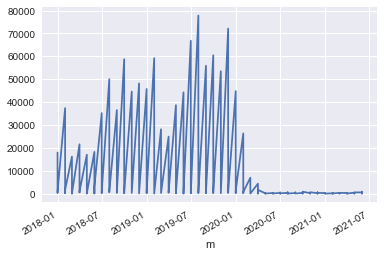

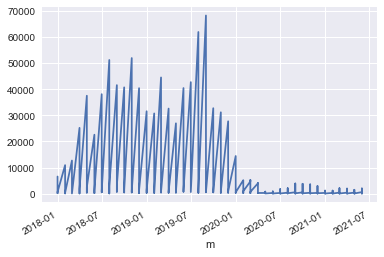

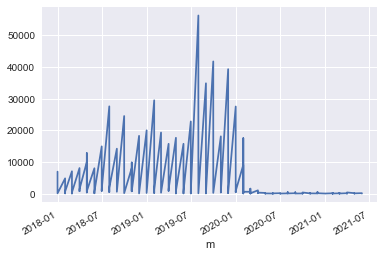

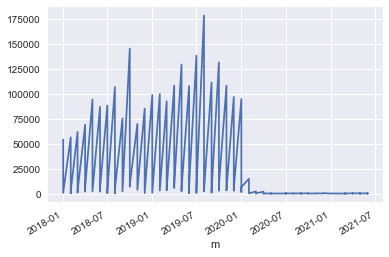

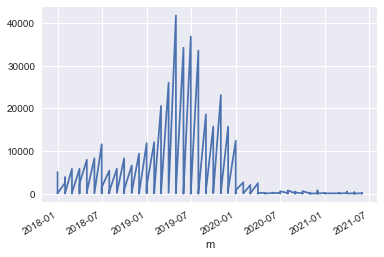

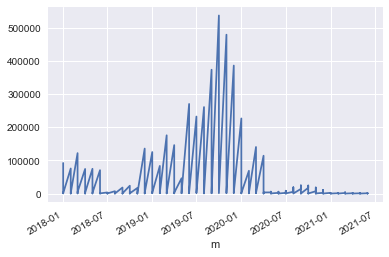

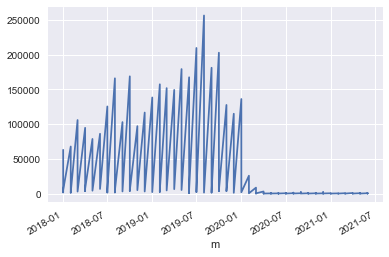

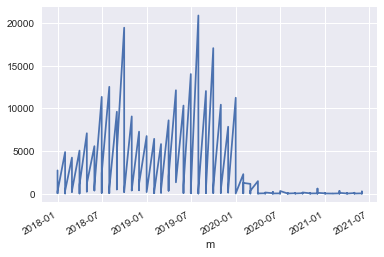

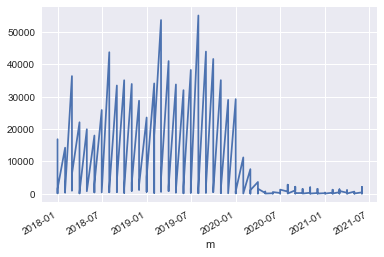

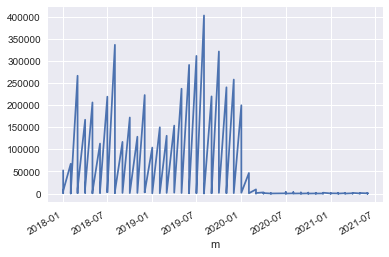

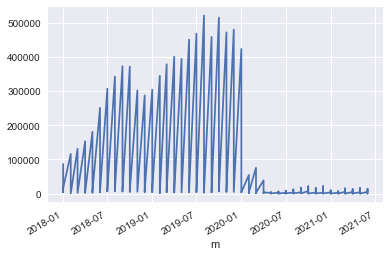

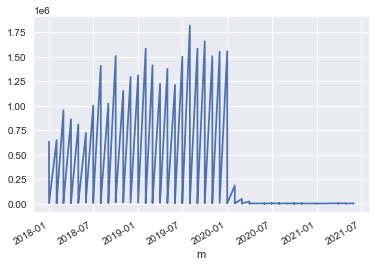

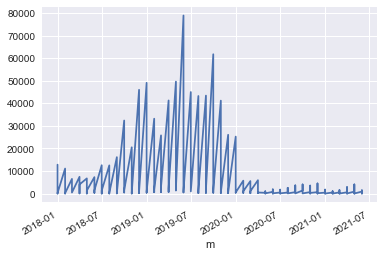

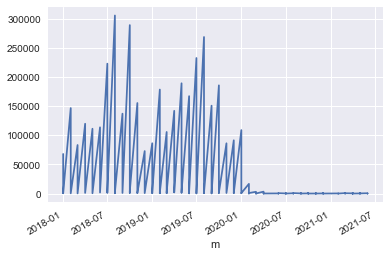

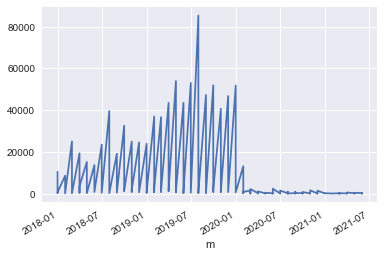

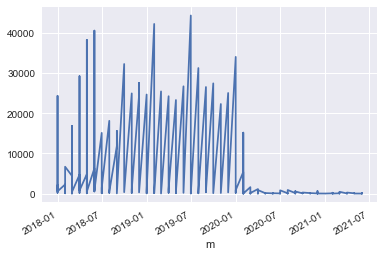

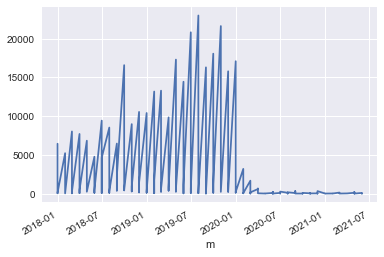

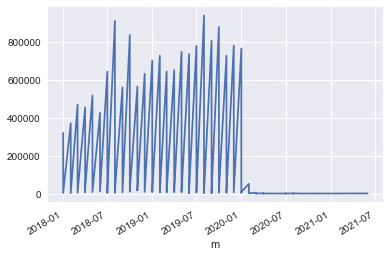

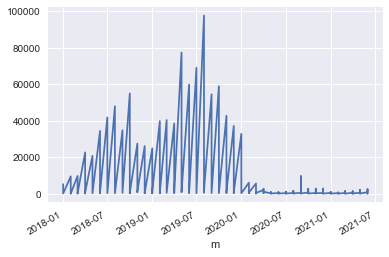

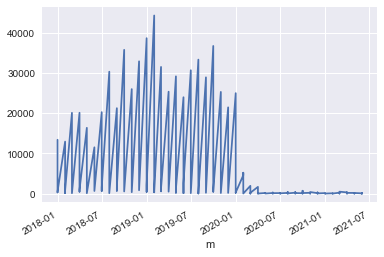

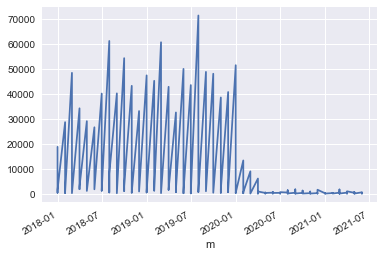

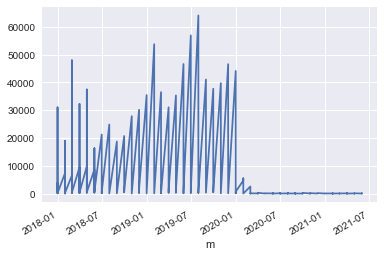

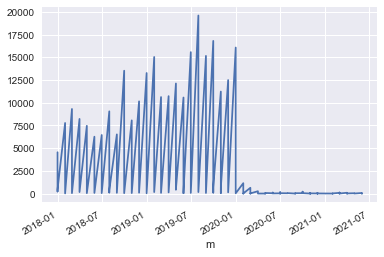

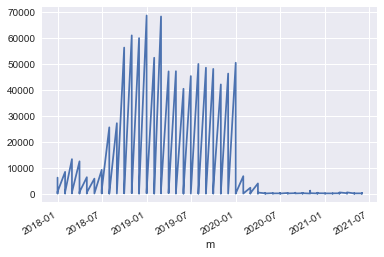

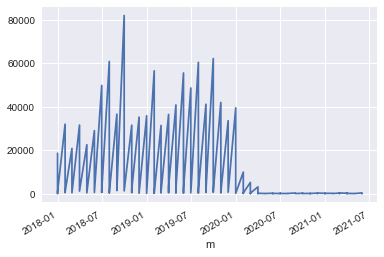

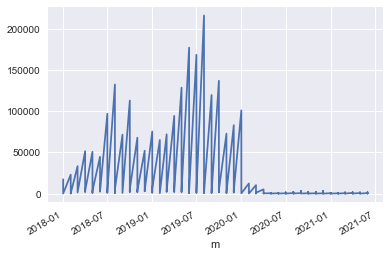

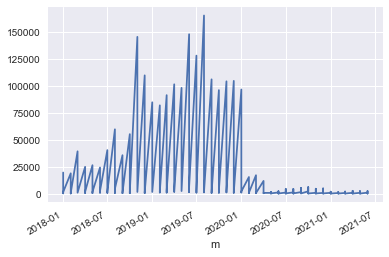

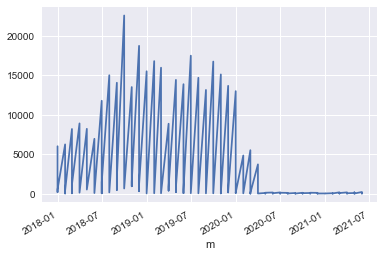

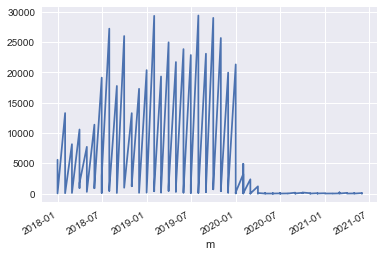

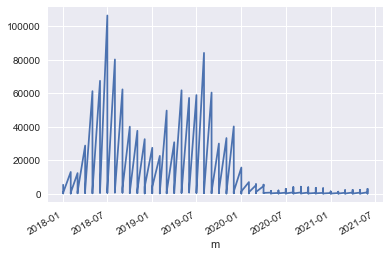

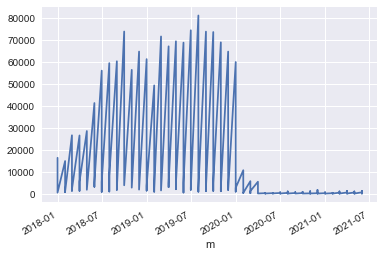

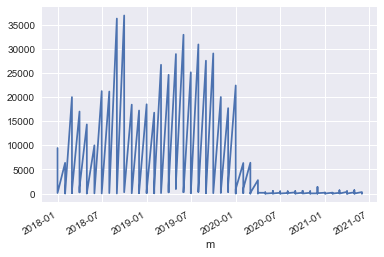

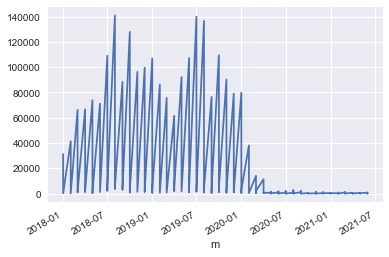

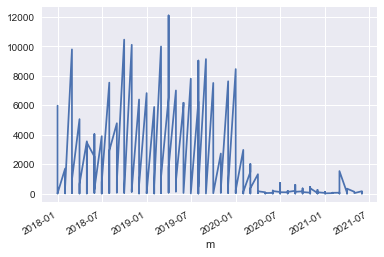

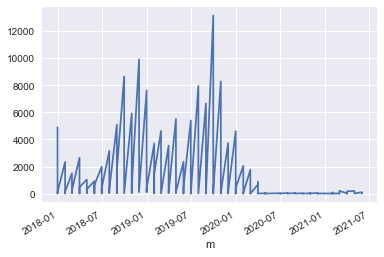

In [377]:
# yearly seasonality가 존재하는지를 보기 위한 시각화(그래프) -> 존재
for c in dong:
    short1_df = short_df[short_df['emd_nm'] == c]
    short_ts = pd.Series(short1_df.visit_pop_cnt.values, index = short1_df.m, name = 'visit_pop_cnt')
    short_ts.index = pd.DatetimeIndex(short_ts.index, freq = short_ts.index.inferred_freq)
    ax = short_ts.plot()
    plt.show()

In [413]:
# 3. visit_pop_cnt
# 국적(nationality) 그룹별로 예측하기
total_short_visit = []
for c in region:
    sum_july3 = 0
    sum_august3 = 0
    new_df = short_df[short_df['emd_nm']==c]
    new_df = new_df.rename(columns = {'m' : 'ds', 'visit_pop_cnt' : 'y'})
    df_grouped = new_df.groupby('nationality_group')
    df_final3 = pd.DataFrame()
    for g in df_grouped.groups:
        group = df_grouped.get_group(g)
        m = Prophet()  # 기본적으로 데이터의 80%크기에서 잠재적으로 changepoint 지정
        m.daily_seasonality=True
        m.weekly_seasonality=True
        m.yearly_seasonality = True
        m.fit(group)
        future = m.make_future_dataframe(freq ='M', periods=2)
        forecast = m.predict(future)
        forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
        df_final3 = pd.merge(df_final3, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

    df_final3 = df_final3[['yhat_' + g for g in df_grouped.groups.keys()]]
    print(c + " 그룹별 예측 결과")
    for i in range(4):
        sum_july3 += df_final3.iloc[-2,i]
        sum_august3 += df_final3.iloc[-1,i]
    print(f'7월의 sum_visit_pop_cnt(방문 인구 합) : {sum_july3}')
    print(f'8월의 sum_visit_pop_cnt(방문 인구 합) : {sum_august3}')
    total_short_visit.append(sum_july3)
    total_short_visit.append(sum_august3)

건입동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : -151.24916704595944
8월의 sum_visit_pop_cnt(방문 인구 합) : 8442.972635677412
구좌읍 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : -379.6980274262264
8월의 sum_visit_pop_cnt(방문 인구 합) : 1993.4241840598715
남원읍 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : -2357.9986013616644
8월의 sum_visit_pop_cnt(방문 인구 합) : 14767.391124696576
노형동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : 16971.663803826297
8월의 sum_visit_pop_cnt(방문 인구 합) : 23234.39183211902
대륜동 그룹별 예측 결과
7월의 sum_visit_pop_cnt(방문 인구 합) : -738.3442699360312
8월의 sum_visit_pop_cnt(방문 인구 합) : 2393.603592110829


KeyboardInterrupt: 

In [419]:
# 국적(nationality) 그룹별로 예측하기
total_short_visit = []
for c in region:
    sum_july4 = 0
    sum_august4 = 0
    new_df = short_df[short_df['emd_nm']==c]
    new_df = new_df.rename(columns = {'m' : 'ds', 'visit_pop_cnt' : 'y'})
    df_grouped = new_df.groupby('nationality_group',dropna = False)
    df_final4 = pd.DataFrame()
    for g in df_grouped.groups:
        group = df_grouped.get_group(g)
        m = Prophet()  # 기본적으로 데이터의 80%크기에서 잠재적으로 changepoint 지정
        m.daily_seasonality=True
        m.weekly_seasonality=True
        m.yearly_seasonality = True   # 앞서 yearly 추세 존재 관측
        m.fit(group)
        future = m.make_future_dataframe(freq ='M', periods=2)
        forecast = m.predict(future)
        forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
        df_final4 = pd.merge(df_final4, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

    df_final4 = df_final4[['yhat_' + g for g in df_grouped.groups.keys()]]
    print(c + " 그룹별 예측 결과")
    for i in range(4):
        sum_july4 += df_final4.iloc[-2,i]
        sum_august4 += df_final4.iloc[-1,i]
    print(f'7월의 sum_visit_pop_cnt(방문 인구 합) : {sum_july4}')
    print(f'8월의 sum_visit_pop_cnt(방문 인구 합) : {sum_august4}')
    total_short_visit.append(sum_july4)
    total_short_visit.append(sum_august4)

AttributeError: 'PrettyDict' object has no attribute 'isna'

In [297]:
total_short_visit = pd.DataFrame(total_short_visit)
total_short_visit= total_short_visit.rename(columns = {0 : 'short_visit'})
total_short_visit.to_csv("단기체류_방문인구.csv",mode='w')

데이터 값이 0에 근접해 있다면, 계절변동에 의해 negative(음수)의 예측값을 내놓을 수 있음. 
따라서 이경우, 음수인 예측값들은 0으로 생각.

## month_resident_pop (거주 인구 데이터)

4. sum_foreign_pop_cnt  ~ sex별로

In [198]:
# sex 그루핑 이미 나눠져 있음 !
resi_df = pd.read_csv(r'C:\Users\이현아\Desktop\월별데이터 정리\month_resident_pop.csv')
resi_df

,base_year,base_month,sex,emd_cd,emd_nm,count_num,sum_resid_pop_cnt,sum_foreign_pop_cnt,sum_total_pop_cnt
0,2018,1,남성,50110590,건입동,1,5085.0,146.0,5231.0
1,2018,1,남성,50110256,구좌읍,1,7965.0,368.0,8333.0
2,2018,1,남성,50130253,남원읍,1,9806.0,428.0,10234.0
3,2018,1,남성,50110660,노형동,1,26286.0,821.0,27107.0
4,2018,1,남성,50130590,대륜동,1,6836.0,83.0,6919.0
...,...,...,...,...,...,...,...,...,...
3607,2021,6,여성,50130320,표선면,1,6033.0,123.0,6156.0
3608,2021,6,여성,50110310,한경면,1,4531.0,100.0,4631.0
3609,2021,6,여성,50110250,한림읍,1,10341.0,1140.0,11481.0
3610,2021,6,여성,50110600,화북동,1,12238.0,161.0,12399.0


### 데이터 전처리

In [199]:
# 우선, 시계열 데이터이므로 날짜를 datetime형식으로 변환
for i in resi_df.index:
    if resi_df.loc[i,'base_month'] < 10:
        resi_df.loc[i,'base_month'] = '0'+ str(resi_df.loc[i,'base_month'])

In [200]:
for i in resi_df.index:
    resi_df.loc[i,'m'] = pd.to_datetime(str(resi_df.loc[i,'base_year'])+ str(resi_df.loc[i,'base_month']), format = '%Y%m')

In [201]:
region = resi_df['emd_nm'].unique()
region = sorted(region)

In [202]:
resim_df = resi_df[resi_df['sex'] == "남성"]    # 남성의 데이터
resif_df = resi_df[resi_df['sex'] == "여성"]    # 여성의 데이터

4. sum_foreign_pop_cnt

In [244]:
# 남성의 데이터
list_male_foreign = []     # 남성 sum_foreign_pop_cnt 각 동별 7,8월 예측값 저장한 리스트
for c in region:
    sum_july4 = 0
    sum_august4 = 0
    new_df = resim_df[resim_df['emd_nm']==c]
    new_df = new_df.rename(columns = {'m' : 'ds', 'sum_foreign_pop_cnt' : 'y'})
    df_final4 = pd.DataFrame()
    m = Prophet()
    m.daily_seasonality=True
    m.weekly_seasonality=True
    m.fit(new_df)
    future = m.make_future_dataframe(freq ='M', periods=2)
    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'})
    df_final4 = pd.merge(df_final4, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)
    df_final4 = df_final7[['yhat_']]
    print(c + " 그룹별 예측 결과")
    sum_july4 += df_final4.iloc[-2,0]
    sum_august4 += df_final4.iloc[-1,0]
    print(f'7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : {sum_july4}')
    print(f'8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : {sum_august4}')
    list_male_foreign.append(sum_july4)
    list_male_foreign.append(sum_august4)

건입동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 150.77934725674848
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 148.8823211748698
구좌읍 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 413.9695347836672
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 381.8756533420009
남원읍 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 441.9806623540595
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 433.0846267987549
노형동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 1078.2179727697676
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 966.9599005529021
대륜동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 95.23758568777062
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 89.71030529969629
대정읍 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 858.8682748216135
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 956.9673657024587
대천동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 70.31548590752746
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 76.54267858877758
도두동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 56.480525510909544
8월의 sum_foreign_pop_cnt(외국인 거주

In [245]:
# 여성의 데이터
list_female_foreign = []     # 여성 sum_foreign_pop_cnt 각 동별 7,8월 예측값 저장한 리스트
for c in region:
    sum_july4 = 0
    sum_august4 = 0
    new_df = resif_df[resif_df['emd_nm']==c]
    new_df = new_df.rename(columns = {'m' : 'ds', 'sum_foreign_pop_cnt' : 'y'})
    df_final4 = pd.DataFrame()
    m = Prophet()
    m.daily_seasonality=True
    m.weekly_seasonality=True
    m.fit(new_df)
    future = m.make_future_dataframe(freq ='M', periods=2)
    forecast = m.predict(future)
    forecast = forecast.rename(columns={'yhat': 'yhat_'})
    df_final4 = pd.merge(df_final8, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)
    df_final4 = df_final4[['yhat_']]
    print(c + " 그룹별 예측 결과")
    sum_july4 += df_final4.iloc[-2,0]
    sum_august4 += df_final4.iloc[-1,0]
    print(f'7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : {sum_july4}')
    print(f'8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : {sum_august4}')
    list_female_foreign.append(sum_july4)
    list_female_foreign.append(sum_august4)

건입동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 92.42067060290934
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 93.78278827683883
구좌읍 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 165.16066955391287
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 163.84729175538058
남원읍 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 199.60647253275053
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 197.6517385986301
노형동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 926.9897267227619
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 847.2920499687355
대륜동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 89.84973183242144
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 83.96938675199655
대정읍 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 692.7064129914389
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 832.2229129391396
대천동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 113.00989100312083
8월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 111.54348710125362
도두동 그룹별 예측 결과
7월의 sum_foreign_pop_cnt(외국인 거주 인구 합) : 46.41560592153622
8월의 sum_foreign_pop_cnt(외국인 

In [248]:
# 각 동 순서대로의 7월 예측값(total_july_foreign)과 8월 예측값(total_august_foreign)
total_july_foreign = [list_male_foreign[i] + list_female_foreign[i] for i in range(86) if i%2 ==0]
total_august_foreign = [list_male_foreign[i] + list_female_foreign[i] for i in range(86) if i%2 ==1]

In [338]:
total_resident_foreign = []       # 각 동 순서대로의 7.8월 예측값 합친 리스트
for i in range(43): 
    total_resident_foreign.append(total_july_foreign[i])
    total_resident_foreign.append(total_august_foreign[i])
total_resident_foreign = pd.DataFrame(total_resident_foreign)
total_resident_foreign = total_resident_foreign.rename(columns = {0 : 'resident_foreign'})
total_resident_foreign.to_csv("외국인거주인구.csv",mode='w')

## month_card_spending (음식 관련 카드소비 데이터)

5. sum_use_amt  ~ mct_cat_nm(업종)별로

In [209]:
card_df = pd.read_csv(r'C:\Users\이현아\Desktop\월별데이터 정리\month_card_spending.csv')
card_df

,m,emd_cd,emd_nm,count_num,mct_cat_cd,mct_cat_nm,sum_use_cnt,sum_use_amt
0,2018-01,50110590,건입동,31,C00400,간식,4540.0,52714107.0
1,2018-01,50110590,건입동,31,C01200,농축수산물,1699.0,180535251.0
2,2018-01,50110590,건입동,31,A00200,마트/슈퍼마켓,17547.0,613458055.0
3,2018-01,50110590,건입동,30,C01400,배달,585.0,11571838.0
4,2018-01,50110590,건입동,9,C00700,부페,55.0,5081850.0
...,...,...,...,...,...,...,...,...
20000,2021-06,50130550,효돈동,30,C00300,아시아음식,720.0,25716378.0
20001,2021-06,50130550,효돈동,20,C00200,양식,225.0,9302910.0
20002,2021-06,50130550,효돈동,16,C00900,주점및주류판매,105.0,4039593.0
20003,2021-06,50130550,효돈동,30,C00500,패스트푸드,1205.0,20827922.0


### 1. mct_cat_nm grouping (업종 그룹화)

In [210]:
card_df['mct_cat_nm'].unique()

array(['간식', '농축수산물', '마트/슈퍼마켓', '배달', '부페', '식품', '아시아음식', '양식',
       '주점및주류판매', '패스트푸드', '한식'], dtype=object)

In [211]:
group1 = ['마트/슈퍼마켓','한식']
group2 = ['식품']
group3 = ['농축수산물']
group4 = ['아시아음식','간식','배달','패스트푸드','양식','부페','주점및주류판매']

In [212]:
for i in card_df.index:
    if card_df.loc[i,'mct_cat_nm'] in group1:
        card_df.loc[i,'mct_cat_nm_group'] = 'group1'
    elif card_df.loc[i,'mct_cat_nm'] in group2:
        card_df.loc[i,'mct_cat_nm_group'] = 'group2'
    elif card_df.loc[i,'mct_cat_nm'] in group3:
        card_df.loc[i,'mct_cat_nm_group'] = 'group3'
    elif card_df.loc[i,'mct_cat_nm'] in group4:
        card_df.loc[i,'mct_cat_nm_group'] = 'group4'

In [213]:
card_df['mct_cat_nm_group'].unique()

array(['group4', 'group3', 'group1', 'group2'], dtype=object)

In [214]:
card_df['mct_cat_nm_group'].value_counts()

group4    12613
group1     3696
group3     1848
group2     1848
Name: mct_cat_nm_group, dtype: int64

### 데이터 전처리

In [215]:
# 우선, 시계열 데이터이므로 날짜를 datetime형식으로 변환
card_df['m'] = pd.to_datetime(card_df.m, format = '%Y-%m')

In [216]:
region = card_df['emd_nm'].unique()
region = sorted(region)

5. sum_use_amt

In [218]:
# 5. sum_use_amt
# mct_cat_nm 그룹별 (mct_cat_nm_group)로 예측하기
total_card_amt = []     # 각 동별 sum_use_amt의 최종 7,8월 예측값 담을 리스트
for c in region:
    sum_july5 = 0
    sum_august5 = 0
    new_df = card_df[card_df['emd_nm']==c]
    new_df = new_df.rename(columns = {'m' : 'ds', 'sum_use_amt' : 'y'})
    df_grouped = new_df.groupby('mct_cat_nm_group')   
    df_final5 = pd.DataFrame()
    for g in df_grouped.groups:
        group = df_grouped.get_group(g)
        m = Prophet()
        m.daily_seasonality=True
        m.weekly_seasonality=True
        m.fit(group)
        future = m.make_future_dataframe(freq ='M', periods=2)
        forecast = m.predict(future)
        forecast = forecast.rename(columns={'yhat': 'yhat_'+g})
        df_final5 = pd.merge(df_final5, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)

    df_final5 = df_final5[['yhat_' + g for g in df_grouped.groups.keys()]]
    print(c + " 그룹별 예측 결과")
    for i in range(4):
        sum_july5 += df_final5.iloc[-2,i]
        sum_august5 += df_final5.iloc[-1,i]
    print(f'7월의 sum_use_amt(결제 금액 합) : {sum_july5}')
    print(f'8월의 sum_use_amt(결제 금액 합) : {sum_august5}')
    total_card_amt.append(sum_july5)
    total_card_amt.append(sum_august5)

건입동 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 1396851806.546457
8월의 sum_use_amt(결제 금액 합) : 1383780964.884054
구좌읍 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 1288956157.709952
8월의 sum_use_amt(결제 금액 합) : 1336962338.4078374
남원읍 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 1446868398.7900312
8월의 sum_use_amt(결제 금액 합) : 1471992352.3044846
노형동 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 7982254880.395504
8월의 sum_use_amt(결제 금액 합) : 7713177314.621764
대륜동 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 1583937816.0176291
8월의 sum_use_amt(결제 금액 합) : 1705709814.0852897
대정읍 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 1929503131.8866262
8월의 sum_use_amt(결제 금액 합) : 2549909555.919261
대천동 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 1659897930.677091
8월의 sum_use_amt(결제 금액 합) : 1543063468.67879
도두동 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 270156921.9292627
8월의 sum_use_amt(결제 금액 합) : 545775796.0322894
동홍동 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 2924532436.5565624
8월의 sum_use_amt(결제 금액 합) : 2793924740.8242993
봉개동 그룹별 예측 결과
7월의 sum_use_amt(결제 금액 합) : 558119791.344254

In [340]:
total_card_amt = pd.DataFrame(total_card_amt)
total_card_amt= total_card_amt.rename(columns = {0 : 'card_amt'})
total_card_amt.to_csv("카드_결제금액.csv",mode='w')

# month_korean (내국인 유동인구 데이터)

> 6. sum_resd_pop_cnt  ~ sex, resd, age_group 변수 통해
>
> 7. sum_work_pop_cnt   ~ sex, resd, age_group 변수 통해


In [220]:
korean_df = pd.read_csv(r'C:\Users\이현아\Desktop\월별데이터 정리\month_korean.csv')
korean_df

,m,resd,sex,age,emd_cd,emd_nm,count_num,sum_resd_pop_cnt,sum_work_pop_cnt,sum_visit_pop_cnt
0,2018-01,그외,남성,0,50110590,건입동,744,0.0000,3132.2282,76353.2457
1,2018-01,그외,남성,0,50110256,구좌읍,744,0.0000,4161.1501,147835.2530
2,2018-01,그외,남성,0,50130253,남원읍,744,0.0000,2121.0335,249159.0777
3,2018-01,그외,남성,0,50110660,노형동,744,0.0000,17475.4153,333967.8223
4,2018-01,그외,남성,0,50130590,대륜동,744,0.0000,5223.4448,308445.7634
...,...,...,...,...,...,...,...,...,...,...
65011,2021-06,제주,여성,80,50130320,표선면,720,133317.8449,373.1435,18236.7638
65012,2021-06,제주,여성,80,50110310,한경면,720,129052.5282,2082.5446,13292.0757
65013,2021-06,제주,여성,80,50110250,한림읍,720,244482.7666,4236.2232,24978.7051
65014,2021-06,제주,여성,80,50110600,화북동,720,202833.2091,2830.6591,32650.5844


### 데이터 전처리

### age grouping

In [221]:
group1= [0,10]
group2 = [20,30]
group3 = [40,50]
group4 = [60]
group5 = [70,80]

In [222]:
for i in korean_df.index:
    if korean_df.loc[i,'age'] in group1:
        korean_df.loc[i,'age_group'] = 'group1'
    elif korean_df.loc[i,'age'] in group2:
        korean_df.loc[i,'age_group'] = 'group2'
    elif korean_df.loc[i,'age'] in group3:
        korean_df.loc[i,'age_group'] = 'group3'
    elif korean_df.loc[i,'age'] in group4:
        korean_df.loc[i,'age_group'] = 'group4'
    elif korean_df.loc[i,'age'] in group5:
        korean.loc[i,'age_group'] = 'group5'

In [223]:
# 동의 종류 확인
region = korean_df['emd_nm'].unique()
region = sorted(region)

## 계층적 시계열

계층적 시계열에 넣어서 그 동의 7,8월 예측값 구하는 과정

Number of time series at the bottom level: 16
Number of time series at the middle level: 8
Number of time series at the middle level: 4


<AxesSubplot:title={'center':'Sum_Resd - total level'}, xlabel='m'>

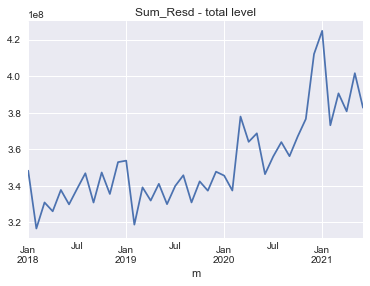

In [224]:
# 우선 동별로 나누지 않은 전체적 상태에서 그래프로 시각화한 후 살펴보기 (Preview 과정)

# 변수에 따라 그룹 지정 -> 상위계층 : age_group, 중위계층 : resd, 하위계층 : sex
korean_df = korean_df.groupby(["m","age_group", "resd", "sex"])["sum_resd_pop_cnt"].sum().reset_index(drop=False)

# 계층구조에서의 하위 계층의 값들, 중위계층의 값들 생성
korean_df["age_resd_sex"] = korean_df.apply(lambda x: f"{x['age_group']}_{x['resd']}_{x['sex']}", axis=1)
korean_df["age_resd"] = korean_df.apply(lambda x: f"{x['age_group']}_{x['resd']}", axis=1)

# 계층 수준 생성
df_bottom_level = korean_df.pivot(index="m", columns="age_resd_sex", values="sum_resd_pop_cnt")
df_middle1_level = korean_df.groupby(["m", "age_resd"]).sum().reset_index(drop=False).pivot(index="m", columns="age_resd", values="sum_resd_pop_cnt")
df_middle2_level = korean_df.groupby(["m", "age_group"]).sum().reset_index(drop=False).pivot(index="m", columns="age_group", values="sum_resd_pop_cnt")
df_total = korean_df.groupby("m")['sum_resd_pop_cnt'].sum().to_frame().rename(columns={'sum_resd_pop_cnt':"total"})

# 계층적 시계열 분석을 위한 데이터프레임 join과정
hierarchy_df = df_bottom_level.join(df_middle1_level).join(df_middle2_level).join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample("MS").sum()

# 각 계층 수준 확인
print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle1_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle2_level.shape[1]}")

# join한 데이터프레임 그래프로 시각화
hierarchy_df["total"].plot(title="Sum_Resd - total level")

 #### 6. sum_resd_pop_cnt


Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<건입동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.26s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163D4DA00>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

건입동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -238509.41855903168
8월의 sum_resd_pop_cnt(거주 인구 합) : 58003.845906215225
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<구좌읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.25s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1638AC250>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

구좌읍 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -85505.44457579253
8월의 sum_resd_pop_cnt(거주 인구 합) : 367364.2185119551
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<남원읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.19s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165BE4C40>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

남원읍 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : 85875.24182780832
8월의 sum_resd_pop_cnt(거주 인구 합) : 547086.8576819059
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<노형동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.26s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163B6E520>


노형동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -5560643.235536094
8월의 sum_resd_pop_cnt(거주 인구 합) : -3478295.35067962
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<대륜동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:38<00:00,  2.73s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163B9D460>


대륜동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -827379.824290794
8월의 sum_resd_pop_cnt(거주 인구 합) : -327905.5857208585
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<대정읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.23s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16566C0A0>


대정읍 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -214474.6339587631
8월의 sum_resd_pop_cnt(거주 인구 합) : 370424.8592701631


Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<대천동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.20s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16362F6A0>


대천동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -263531.1101846233
8월의 sum_resd_pop_cnt(거주 인구 합) : -87649.11829119132
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<도두동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:27<00:00,  2.43s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16627B0D0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

도두동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -78485.69849382355
8월의 sum_resd_pop_cnt(거주 인구 합) : -31632.07503123538
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<동홍동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.23s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C166218AC0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

동홍동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -1204330.4331052662
8월의 sum_resd_pop_cnt(거주 인구 합) : -510409.69579732034
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<봉개동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:41<00:00,  2.82s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1637DC160>


봉개동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -127487.17275504506
8월의 sum_resd_pop_cnt(거주 인구 합) : 12617.24223798466
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<삼도1동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:33<00:00,  2.61s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163D713A0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

삼도1동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -297575.0026475296
8월의 sum_resd_pop_cnt(거주 인구 합) : -11598.768161482738
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<삼도2동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [02:11<00:00,  3.67s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165BAB220>


삼도2동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -199335.82669822618
8월의 sum_resd_pop_cnt(거주 인구 합) : -38387.33755357239


Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<삼양동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:31<00:00,  2.55s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165B64A90>


삼양동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -2070185.60037122
8월의 sum_resd_pop_cnt(거주 인구 합) : -1354718.6101431227
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<서홍동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:32<00:00,  2.57s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16685AE80>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

서홍동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -264134.982034372
8월의 sum_resd_pop_cnt(거주 인구 합) : -66894.28447912617
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<성산읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.24s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165BDC640>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

성산읍 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -157839.78264333267
8월의 sum_resd_pop_cnt(거주 인구 합) : 390920.1200789466
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<송산동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.20s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165C17070>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

송산동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : 40114.62421971893
8월의 sum_resd_pop_cnt(거주 인구 합) : 87296.07675873814
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<아라동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:30<00:00,  2.52s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C166869610>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

아라동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -3636634.346269705
8월의 sum_resd_pop_cnt(거주 인구 합) : -2563811.6787615605
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<안덕면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.26s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16371AB80>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

안덕면 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -749134.7681409189
8월의 sum_resd_pop_cnt(거주 인구 합) : -262977.70361585415
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<애월읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:29<00:00,  2.47s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C166869B20>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

애월읍 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -1553066.6469269176
8월의 sum_resd_pop_cnt(거주 인구 합) : -323036.2709583603
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<연동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:30<00:00,  2.51s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16618FE80>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

연동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -4280529.931390009
8월의 sum_resd_pop_cnt(거주 인구 합) : -2571112.2709652716
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<영천동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:46<00:00,  2.95s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1656D6520>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

영천동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : 50728.893348226404
8월의 sum_resd_pop_cnt(거주 인구 합) : 154047.53778053273
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<예래동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:25<00:00,  2.38s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16574CE50>


예래동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -89000.50954923221
8월의 sum_resd_pop_cnt(거주 인구 합) : -6158.888570463714
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<오라동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:32<00:00,  2.56s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165BC2C70>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

오라동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -1031351.8907984055
8월의 sum_resd_pop_cnt(거주 인구 합) : -513138.6554682049
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<외도동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:38<00:00,  2.75s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1668A2070>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

외도동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -933052.8561509382
8월의 sum_resd_pop_cnt(거주 인구 합) : -675138.7280313782
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<용담1동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:32<00:00,  2.56s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C168BC3550>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

용담1동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -166956.88954998687
8월의 sum_resd_pop_cnt(거주 인구 합) : 95312.44763790425
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<용담2동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.27s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C166869610>


용담2동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -403033.7356135282
8월의 sum_resd_pop_cnt(거주 인구 합) : 20556.675393215846
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<우도면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:31<00:00,  2.53s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1636501F0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

우도면 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : 83033.7080480268
8월의 sum_resd_pop_cnt(거주 인구 합) : 121744.15011548693
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<이도1동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:34<00:00,  2.64s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1637664C0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

이도1동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -236189.2648105944
8월의 sum_resd_pop_cnt(거주 인구 합) : 29779.51830043916
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<이도2동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:28<00:00,  2.46s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163B6F580>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

이도2동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -4951622.390488333
8월의 sum_resd_pop_cnt(거주 인구 합) : -2790016.162496019
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<이호동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:28<00:00,  2.46s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165C42550>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

이호동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -205463.88614638132
8월의 sum_resd_pop_cnt(거주 인구 합) : -75846.484725856
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<일도1동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:36<00:00,  2.68s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165BABA60>


일도1동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -52362.09894838516
8월의 sum_resd_pop_cnt(거주 인구 합) : -22650.11431486687
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<일도2동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:34<00:00,  2.62s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163653B20>


일도2동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -2085427.253764209
8월의 sum_resd_pop_cnt(거주 인구 합) : -892256.8994437897
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<정방동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:32<00:00,  2.56s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C166805040>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

정방동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : 10028.59896406569
8월의 sum_resd_pop_cnt(거주 인구 합) : 87019.38898808483
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<조천읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:29<00:00,  2.50s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163910D60>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

조천읍 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -843523.0317525144
8월의 sum_resd_pop_cnt(거주 인구 합) : -262984.11000958126
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<중문동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.24s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1639E8A30>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

중문동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -253264.46105181013
8월의 sum_resd_pop_cnt(거주 인구 합) : 22985.938593394665
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<중앙동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:24<00:00,  2.34s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1655C4BE0>


중앙동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -104905.22183326025
8월의 sum_resd_pop_cnt(거주 인구 합) : -63223.13229226826
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<천지동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:24<00:00,  2.34s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163D90AC0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

천지동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -34078.98696114013
8월의 sum_resd_pop_cnt(거주 인구 합) : 4401.523190002837
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<추자면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.21s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C168C7D3A0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

추자면 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : 130969.47298322029
8월의 sum_resd_pop_cnt(거주 인구 합) : 196268.88468217725
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<표선면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:30<00:00,  2.52s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165B8BA60>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

표선면 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -85156.9710164581
8월의 sum_resd_pop_cnt(거주 인구 합) : 246705.0999094557
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<한경면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:40<00:00,  2.80s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165BA1C70>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

한경면 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : 255913.2410156703
8월의 sum_resd_pop_cnt(거주 인구 합) : 495922.27487618686
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<한림읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:36<00:00,  2.67s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163939160>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

한림읍 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -602198.9845483763
8월의 sum_resd_pop_cnt(거주 인구 합) : 142874.41512839514
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<화북동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:23<00:00,  2.33s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1637DB640>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

화북동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -2196141.2924500173
8월의 sum_resd_pop_cnt(거주 인구 합) : -1131573.7325086363
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<효돈동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.23s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1637B1880>


효돈동 그룹별 예측 결과
7월의 sum_resd_pop_cnt(거주 인구 합) : -39288.06284472499
8월의 sum_resd_pop_cnt(거주 인구 합) : 75360.0227608005


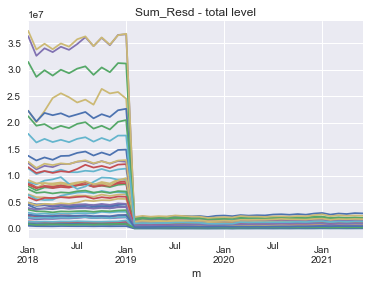

In [226]:
# 6. sum_resd_pop_cnt
# 각 동별로 나누고 계층적 시계열 분석 수행
total_korean_resd = []   # 각 동별 sum_resd_pop_cnt의 7,8월 예측값 담은 리스트
for c in region:
    # 동별 데이터 셋 지정
    hier = korean[korean['emd_nm'] == c]
    
    # 변수에 따라 그룹 지정 -> 상위계층 : age_group, 중위계층 : resd, 하위계층 : sex
    korean_df = hier.groupby(["m","age_group", "resd", "sex"])["sum_resd_pop_cnt"].sum().reset_index(drop=False)
    
    # 계층구조에서의 하위 계층의 값들, 중위계층의 값들 생성
    korean_df["age_resd_sex"] = korean_df.apply(lambda x: f"{x['age_group']}_{x['resd']}_{x['sex']}", axis=1)
    korean_df["age_resd"] = korean_df.apply(lambda x: f"{x['age_group']}_{x['resd']}", axis=1)
    
    # 계층 수준 생성
    df_bottom_level = korean_df.pivot(index="m", columns="age_resd_sex", values="sum_resd_pop_cnt")
    df_middle1_level = korean_df.groupby(["m", "age_resd"]).sum().reset_index(drop=False).pivot(index="m", columns="age_resd", values="sum_resd_pop_cnt")
    df_middle2_level = korean_df.groupby(["m", "age_group"]).sum().reset_index(drop=False).pivot(index="m", columns="age_group", values="sum_resd_pop_cnt")
    df_total = korean_df.groupby("m")['sum_resd_pop_cnt'].sum().to_frame().rename(columns={'sum_resd_pop_cnt':"total"})
    
    # 계층적 시계열 분석을 위한 데이터프레임 join과정 
    hierarchy_df = df_bottom_level.join(df_middle1_level).join(df_middle2_level).join(df_total)
    hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
    hierarchy_df = hierarchy_df.resample("MS").sum()
    
    # 각 계층 수준 확인
    print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
    print(f"Number of time series at the middle level: {df_middle1_level.shape[1]}")
    print(f"Number of time series at the middle level: {df_middle2_level.shape[1]}")
    
    # join한 데이터프레임 그래프로 시각화
    print("<" + c + ">")
    hierarchy_df["total"].plot(title="Sum_Resd - total level")
    
    # 상향식 접근 방법 - model은 prophet, method는 OLS로 예측
    ages = korean_df["age_group"].unique()     # age_group 확인
    resds = korean_df["age_resd"].unique()     # age_resd 확인
    sexs = korean_df['age_resd_sex'].unique()  # age_resd_sex 확인

    total = {'total': list(ages)}
    age = {k: [v for v in resds if v.startswith(k)] for k in ages}
    resd = {k: [v for v in sexs if v.startswith(k)] for k in resds}

    hierarchy = {**total, **age, **resd}

    model_td_prophet = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
    model_td_prophet= model_td_prophet.fit(hierarchy_df, hierarchy)  # prophet에 적합
    pred_td_prophet = model_td_prophet.predict(steps_ahead = 2)      # 예측값
    
    print(c + " 그룹별 예측 결과")
    sum_july_resd = pred_td_prophet.iloc[-2][0]
    sum_august_resd = pred_td_prophet.iloc[-1][0]
    print(f'7월의 sum_resd_pop_cnt(거주 인구 합) : {sum_july_resd}')
    print(f'8월의 sum_resd_pop_cnt(거주 인구 합) : {sum_august_resd}')
    total_korean_resd.append(sum_july_resd)
    total_korean_resd.append(sum_august_resd)

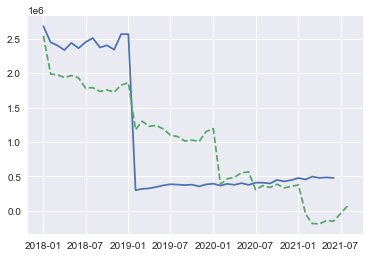

In [227]:
plt.plot(hierarchy_df["total"])
plt.plot(pred_td_prophet["total"],linestyle = 'dashed')

In [341]:
total_korean_resd = pd.DataFrame(total_korean_resd)
total_korean_resd= total_korean_resd.rename(columns = {0 : 'korean_resd'})
total_korean_resd.to_csv("내국인_거주인구.csv",mode='w')

 #### 7. sum_work_pop_cnt 예측값 구하기 

Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<건입동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:28<00:00,  2.45s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C168C0A160>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

건입동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -105491.80627774072
8월의 sum_work_pop_cnt(근무 인구 합) : -80851.36112154252
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<구좌읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.22s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1639122E0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

구좌읍 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -171727.43227204832
8월의 sum_work_pop_cnt(근무 인구 합) : -156160.47816187632
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<남원읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:28<00:00,  2.45s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1637B1460>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

남원읍 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -113688.23202367235
8월의 sum_work_pop_cnt(근무 인구 합) : -84855.35501534799
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<노형동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.23s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163B6E7C0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

노형동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -798244.5022553097
8월의 sum_work_pop_cnt(근무 인구 합) : -663138.6756149214
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<대륜동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.25s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1655C4BB0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

대륜동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -126262.69900394687
8월의 sum_work_pop_cnt(근무 인구 합) : -56035.010610353114
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<대정읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.25s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1660E2910>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

대정읍 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -134231.44267327042
8월의 sum_work_pop_cnt(근무 인구 합) : -119795.73634158101
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<대천동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.23s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C168511A30>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

대천동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -45261.450170711774
8월의 sum_work_pop_cnt(근무 인구 합) : -20551.1531100758
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<도두동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.24s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16852A880>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

도두동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -21950.5674501928
8월의 sum_work_pop_cnt(근무 인구 합) : -9303.566319273978
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<동홍동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:24<00:00,  2.33s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1685094F0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

동홍동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -153212.7156394568
8월의 sum_work_pop_cnt(근무 인구 합) : -98958.33056400779
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<봉개동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.22s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163D07D60>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

봉개동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -101995.66715622328
8월의 sum_work_pop_cnt(근무 인구 합) : -81037.71846032345
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<삼도1동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.27s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C168B65CD0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

삼도1동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -56368.03406222717
8월의 sum_work_pop_cnt(근무 인구 합) : -36857.09533577789
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<삼도2동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:20<00:00,  2.24s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C169C5F3A0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

삼도2동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -90878.14863183438
8월의 sum_work_pop_cnt(근무 인구 합) : -91005.44585776812
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<삼양동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.21s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C166278460>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

삼양동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -89239.56808953286
8월의 sum_work_pop_cnt(근무 인구 합) : -50574.61250421636
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<서홍동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.17s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1661E8610>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

서홍동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -26301.502580234217
8월의 sum_work_pop_cnt(근무 인구 합) : -4403.119716955634
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<성산읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.20s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16371A400>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

성산읍 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -94715.80060596422
8월의 sum_work_pop_cnt(근무 인구 합) : -58746.87522788926
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<송산동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.18s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C168572460>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

송산동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -805.0704748648033
8월의 sum_work_pop_cnt(근무 인구 합) : 9455.42433701587
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<아라동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.18s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16608CCA0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

아라동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -745485.6556574246
8월의 sum_work_pop_cnt(근무 인구 합) : -685885.8027251273
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<안덕면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.22s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16916A400>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

안덕면 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -283688.4902545021
8월의 sum_work_pop_cnt(근무 인구 합) : -208695.81384407068
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<애월읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.20s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C168CBA1F0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

애월읍 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -347369.6139506177
8월의 sum_work_pop_cnt(근무 인구 합) : -239299.04306083592
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<연동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:22<00:00,  2.29s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1656B6B50>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

연동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -727552.6324666038
8월의 sum_work_pop_cnt(근무 인구 합) : -510670.08382203116
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<영천동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:26<00:00,  2.41s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1684E06A0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

영천동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -93173.28119981156
8월의 sum_work_pop_cnt(근무 인구 합) : -85111.3496904524
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<예래동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.22s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165607CD0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

예래동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -110321.25323627927
8월의 sum_work_pop_cnt(근무 인구 합) : -75407.66280660553
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<오라동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:37<00:00,  2.70s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C162521F40>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

오라동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -140452.12762500436
8월의 sum_work_pop_cnt(근무 인구 합) : -64902.17015907938
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<외도동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:17<00:00,  2.16s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1656B65B0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

외도동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -68939.46640027457
8월의 sum_work_pop_cnt(근무 인구 합) : -50899.96202625954
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<용담1동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.19s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16616A850>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

용담1동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -29679.95519088121
8월의 sum_work_pop_cnt(근무 인구 합) : -10360.178821018486
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<용담2동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.22s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1656D6220>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

용담2동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -326195.2616745586
8월의 sum_work_pop_cnt(근무 인구 합) : -224528.58375805974
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<우도면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.19s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1638AC400>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

우도면 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -11468.89252613048
8월의 sum_work_pop_cnt(근무 인구 합) : -10229.216896523969
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<이도1동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:22<00:00,  2.30s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C168B365B0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

이도1동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -132466.29588967338
8월의 sum_work_pop_cnt(근무 인구 합) : -64691.12510593618
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<이도2동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:23<00:00,  2.32s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1656AEA30>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

이도2동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -888711.1211508855
8월의 sum_work_pop_cnt(근무 인구 합) : -618824.6218277495
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<이호동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:29<00:00,  2.50s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1685763D0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

이호동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -30625.906360372253
8월의 sum_work_pop_cnt(근무 인구 합) : -13591.339853110716
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<일도1동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:28<00:00,  2.45s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1638AE340>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

일도1동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -30985.22176190176
8월의 sum_work_pop_cnt(근무 인구 합) : -21059.712405498354
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<일도2동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.19s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1684F18B0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

일도2동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -147586.47909953495
8월의 sum_work_pop_cnt(근무 인구 합) : -79563.74557137815
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<정방동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.17s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C166278790>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

정방동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -49744.23058243326
8월의 sum_work_pop_cnt(근무 인구 합) : -40377.832856322246
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<조천읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.17s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16384F760>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

조천읍 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -190141.25198738923
8월의 sum_work_pop_cnt(근무 인구 합) : -119385.94920941375
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<중문동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:21<00:00,  2.26s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C165B81700>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

중문동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -91622.23289700829
8월의 sum_work_pop_cnt(근무 인구 합) : -85362.46535032945
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<중앙동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:18<00:00,  2.17s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1660E2B80>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

중앙동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -73508.53572049338
8월의 sum_work_pop_cnt(근무 인구 합) : -48139.30569271397
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<천지동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:29<00:00,  2.50s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1636EFB20>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

천지동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -3936.827029697472
8월의 sum_work_pop_cnt(근무 인구 합) : 2563.4259186048766
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<추자면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:45<00:00,  2.94s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16566C310>


추자면 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : 5460.881912079692
8월의 sum_work_pop_cnt(근무 인구 합) : 16106.066306576005
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<표선면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:47<00:00,  2.99s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C1684F1CA0>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

표선면 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -89132.9830066748
8월의 sum_work_pop_cnt(근무 인구 합) : -58658.18265390355
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<한경면>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:47<00:00,  3.00s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16574FF70>
Fitting models:   0%|                                                                           | 0/36 [00:00<?, ?it/s]

한경면 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -38541.815599622336
8월의 sum_work_pop_cnt(근무 인구 합) : -27732.417919536685
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<한림읍>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:45<00:00,  2.93s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C163B6EE20>


한림읍 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -189377.85820954075
8월의 sum_work_pop_cnt(근무 인구 합) : -164016.14288932673
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<화북동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:48<00:00,  3.00s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16916A400>


화북동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -319692.65927397023
8월의 sum_work_pop_cnt(근무 인구 합) : -286442.5152354163
Number of time series at the bottom level: 20
Number of time series at the middle level: 10
Number of time series at the middle level: 5
<효돈동>


Fitting models: 100%|██████████████████████████████████████████████████████████████████| 36/36 [01:46<00:00,  2.95s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x000001C16362FAF0>


효돈동 그룹별 예측 결과
7월의 sum_work_pop_cnt(근무 인구 합) : -23116.757830844064
8월의 sum_work_pop_cnt(근무 인구 합) : -15206.200226760948


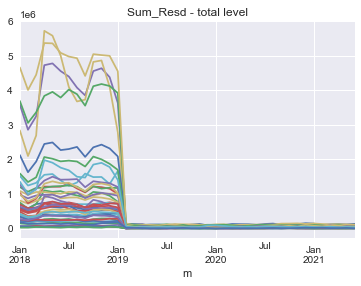

In [267]:
total_korean_work = []   # 각 동별 sum_work_pop_cnt의 7,8월 예측값 담은 리스트
for c in region:
    # 동별 데이터 셋 지정
    hier = korean[korean['emd_nm'] == c]
    
    # 변수에 따라 그룹 지정 -> 상위계층 : age_group, 중위계층 : resd, 하위계층 : sex
    korean_df = hier.groupby(["m","age_group", "resd", "sex"])["sum_work_pop_cnt"].sum().reset_index(drop=False)
    
    # 계층구조에서의 하위 계층의 값들, 중위계층의 값들 생성
    korean_df["age_resd_sex"] = korean_df.apply(lambda x: f"{x['age_group']}_{x['resd']}_{x['sex']}", axis=1)
    korean_df["age_resd"] = korean_df.apply(lambda x: f"{x['age_group']}_{x['resd']}", axis=1)
    
    # 계층 수준 생성
    df_bottom_level = korean_df.pivot(index="m", columns="age_resd_sex", values="sum_work_pop_cnt")
    df_middle1_level = korean_df.groupby(["m", "age_resd"]).sum().reset_index(drop=False).pivot(index="m", columns="age_resd", values="sum_work_pop_cnt")
    df_middle2_level = korean_df.groupby(["m", "age_group"]).sum().reset_index(drop=False).pivot(index="m", columns="age_group", values="sum_work_pop_cnt")
    df_total = korean_df.groupby("m")['sum_work_pop_cnt'].sum().to_frame().rename(columns={'sum_work_pop_cnt':"total"})
    
    # 계층적 시계열을 위한 데이터프레임 join과정 
    hierarchy_df = df_bottom_level.join(df_middle1_level).join(df_middle2_level).join(df_total)
    hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
    hierarchy_df = hierarchy_df.resample("MS").sum()
    
    # 각 계층 수준 확인
    print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
    print(f"Number of time series at the middle level: {df_middle1_level.shape[1]}")
    print(f"Number of time series at the middle level: {df_middle2_level.shape[1]}")
    
    # join한 데이터프레임 그래프로 시각화
    print("<" + c + ">")
    hierarchy_df["total"].plot(title="Sum_Resd - total level")
    
    # 상향식 접근 방법 - model은 prophet, method는 OLS로 예측
    ages = korean_df["age_group"].unique()     # age_group 확인
    resds = korean_df["age_resd"].unique()     # age_resd 확인
    sexs = korean_df['age_resd_sex'].unique()  # age_resd_sex 확인

    total = {'total': list(ages)}
    age = {k: [v for v in resds if v.startswith(k)] for k in ages}
    resd = {k: [v for v in sexs if v.startswith(k)] for k in resds}

    hierarchy = {**total, **age, **resd}

    model_td_prophet = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
    model_td_prophet= model_td_prophet.fit(hierarchy_df, hierarchy)   # prophet에 적합
    pred_td_prophet = model_td_prophet.predict(steps_ahead = 2)       # 예측값
    
    print(c + " 그룹별 예측 결과")# 이거 실행!
    sum_july_work = pred_td_prophet.iloc[-2][0]
    sum_august_work = pred_td_prophet.iloc[-1][0]
    print(f'7월의 sum_work_pop_cnt(근무 인구 합) : {sum_july_work}')
    print(f'8월의 sum_work_pop_cnt(근무 인구 합) : {sum_august_work}')
    total_korean_work.append(sum_july_work)
    total_korean_work.append(sum_august_work)

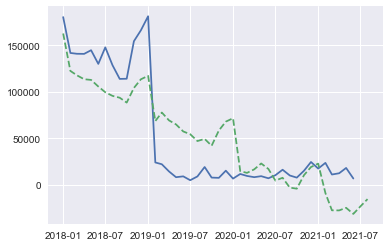

In [268]:
plt.plot(hierarchy_df["total"])
plt.plot(pred_td_prophet["total"],linestyle = 'dashed')

In [342]:
total_korean_work = pd.DataFrame(total_korean_work)
total_korean_work= total_korean_work.rename(columns = {0 : 'korean_work'})
total_korean_work.to_csv("내국인_근무인구.csv",mode='w')

# month_food_waste

8. sum_em_cnt

In [275]:
waste_df = pd.read_csv(r'C:\Users\이현아\Desktop\월별데이터 정리\month_food_waste.csv')

In [276]:
waste_df['m'] = pd.to_datetime(waste_df.m, format = '%Y-%m')

In [277]:
# 동, 읍, 면의 이름
region = waste_df['emd_nm'].unique()
region = sorted(region)

In [278]:
total_waste_cnt = []    # 각 지역별 sum_em_cnt의 7,8월 예측값 저장한 리스트
for c in region:
    sum_july8 = 0     # 해당 지역의 7월 예측값
    sum_august8 = 0   # 해당 지역의 8월 예측값
    new_df = waste_df[waste_df['emd_nm'] == c]      
    new_df = new_df.rename(columns = {'m':'ds', 'sum_em_cnt' : 'y'})   # ds, y로 변수명 변경
    df_final8 = pd.DataFrame()    # 예측값 넣을 dataframe
    
    m = Prophet()
    m.daily_seasonality = True
    m.weekly_seasonality = True
    m.fit(new_df)

    future = m.make_future_dataframe(freq = 'M', periods = 2)
    forecast = m.predict(future)   # 예측값
    forecast = forecast.rename(columns={'yhat': 'yhat_'}) 
    df_final8 = pd.merge(df_final8, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)
    
    print(c + "그룹별 예측 결과")
    sum_july8 += df_final8.iloc[-2,-1]      # 7월의 배출 건수 합 예측값
    sum_august8 += df_final8.iloc[-1,-1]    # 8월의 배출 건수 합 예측값
    print(f'7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : {sum_july8}')
    print(f'8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : {sum_august8}')
    total_waste_cnt.append(sum_july8)
    total_waste_cnt.append(sum_august8)

건입동그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 25697.62004590088
8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 24206.430155625796
구좌읍그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 15118.363043096873
8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 15407.11919448338
남원읍그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 22582.492491323464
8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 18143.97670702295
노형동그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 157937.36782853326
8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 153172.76998096766
대륜동그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 29005.157622737166
8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 22993.53191175552
대정읍그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 44521.787016359056
8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 49355.527495646435
대천동그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 34970.92239961978
8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 30264.830347902185
도두동그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 10092.934163401678
8월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 10414.365127605904
동홍동그룹별 예측 결과
7월의 sum_em_cnt(음식물 쓰레기 배출 건수) : 69069.89522765973
8월의 sum_em_cnt(음식물 쓰레기

In [344]:
# 각 지역별 배출 건수 합 7,8월 예측값 (건입동 7,8월 예측값 -> 구좌읍 7,8월 예측값순)
total_waste_cnt = pd.DataFrame(total_waste_cnt)
total_waste_cnt= total_waste_cnt.rename(columns = {0 : 'waste_cnt'})
total_waste_cnt.to_csv("음식물쓰레기_배출건수.csv",mode='w')